In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import cellij
import numpy as np
import matplotlib.pyplot as plt

In [22]:
mdata = cellij._data.Importer().load_CLL()
mdata["mrna"]

AnnData object with n_obs × n_vars = 136 × 5000

In [23]:
model = cellij.models.MOFA(n_factors=50)
model.add_data(data=mdata, na_strategy="knn_by_obs")

In [24]:
model.fit(likelihood="Normal",  epochs=30)

Epoch      0:     6582746.30


In [28]:
model.save("mofa.pkl")

In [29]:
mofa = cellij.utils.load_model("mofa.pkl")

<AxesSubplot:>

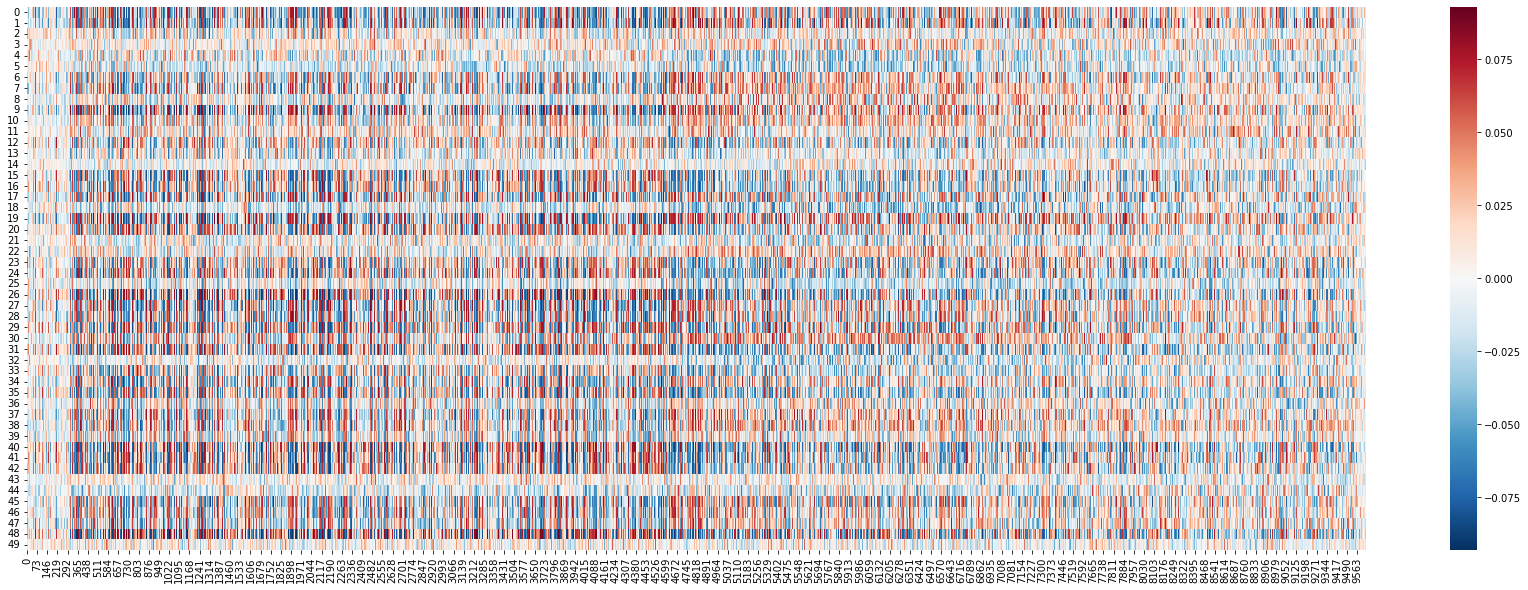

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
sns.heatmap(mofa.get_w(format="numpy"), center=0, cmap='RdBu_r')

(50, 9627) (200, 50)


<AxesSubplot:>

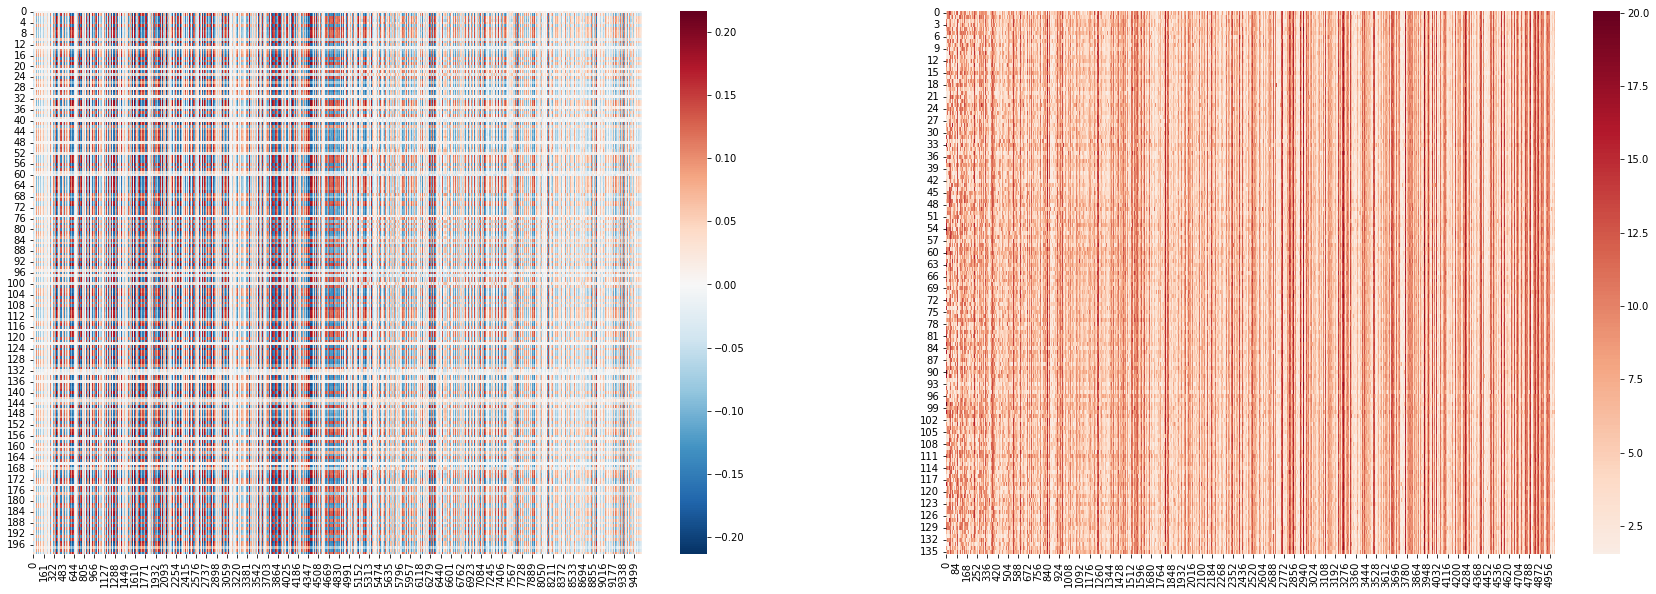

In [27]:
w = model.get_w()
z = model.get_z()

print(w.shape, z.shape)

xhat = np.matmul(z,w)

fig, ax = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(xhat, center=0, cmap='RdBu_r', ax=ax[0])
sns.heatmap(mdata["mrna"].X, center=0, cmap='RdBu_r', ax=ax[1])